# 1. Setup

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Data Cleaning

In [4]:
import cv2
import imghdr

In [5]:
# Directory containing the image data
data_dir = r'C:\Users\Marvin\Documents\WBS\Final_Project\Data\data' 

In [65]:
class_names = os.listdir(data_dir)

In [66]:
num_classes = len(os.listdir(data_dir))

In [8]:
# List of image extensions
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [10]:
# Remove images with invalid extensions
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                # os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

: 

# 3. Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 96370 files belonging to 62 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [21]:
batch = data_iterator.next()

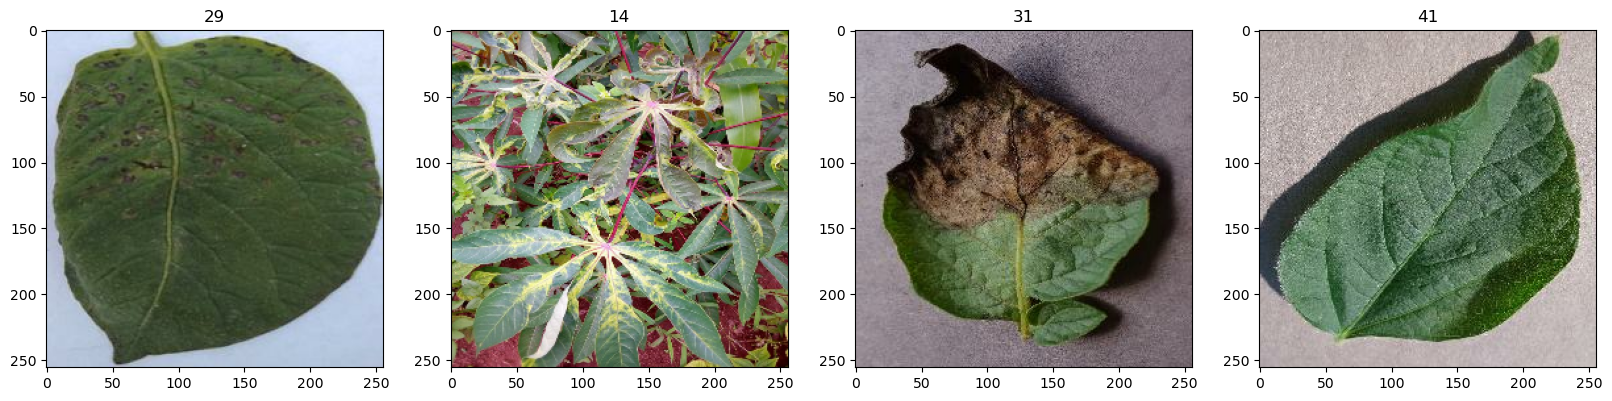

In [22]:
# Display sample images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Preprocess

### 4.1. Scaling

In [37]:
data_scaled = data.map(lambda x,y: (x/255, tf.one_hot(y, num_classes)))

In [38]:
data_scaled.as_numpy_iterator().next()

(array([[[[5.7647061e-01, 6.1176473e-01, 6.0000002e-01],
          [5.4901963e-01, 5.8431375e-01, 5.7254905e-01],
          [5.2156866e-01, 5.5686277e-01, 5.4509807e-01],
          ...,
          [4.9411765e-01, 5.1764709e-01, 5.1764709e-01],
          [5.0196081e-01, 5.2549022e-01, 5.2549022e-01],
          [5.0588238e-01, 5.2941179e-01, 5.2941179e-01]],
 
         [[5.3333336e-01, 5.6862748e-01, 5.5686277e-01],
          [5.2941179e-01, 5.6470591e-01, 5.5294120e-01],
          [5.2549022e-01, 5.6078434e-01, 5.4901963e-01],
          ...,
          [4.7843137e-01, 5.0196081e-01, 5.0196081e-01],
          [4.7843137e-01, 5.0196081e-01, 5.0196081e-01],
          [4.7450981e-01, 4.9803922e-01, 4.9803922e-01]],
 
         [[4.9803922e-01, 5.3333336e-01, 5.2156866e-01],
          [5.2156866e-01, 5.5686277e-01, 5.4509807e-01],
          [5.4117650e-01, 5.7647061e-01, 5.6470591e-01],
          ...,
          [4.8627451e-01, 5.0980395e-01, 5.0980395e-01],
          [4.7450981e-01, 4.9803922e-

In [26]:
# validate scaling 0-1

scaled_iterator = data_scaled.as_numpy_iterator()
batch_scaled = scaled_iterator.next()
batch_scaled[0].max()

1.0

### 4.2. Splitting

In [39]:
train_size = int(len(data_scaled)*.7)
val_size = int(len(data_scaled)*.2)
test_size = int(len(data_scaled)*.1)

In [40]:
train_size

2108

In [41]:
train = data_scaled.take(train_size)
val = data_scaled.skip(train_size).take(val_size)
test = data_scaled.skip(train_size+val_size).take(test_size)

# 5. Deep Learning Model

### 5.1. Building

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [43]:
model = Sequential()

In [44]:
# Layers
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))

# Output layer for multiple classes with softmax activation
model.add(Dense(num_classes, activation='softmax'))

In [45]:
# Compile the model with categorical crossentropy loss function
model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

### 5.2. Training

In [47]:
# Directory for storing TensorBoard logs
logdir=r'C:\Users\Marvin\Documents\WBS\Final_Project\logs'

In [48]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [49]:
# Train the model
hist = model.fit(train, epochs=50, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/50
2108/2108 [==============================] - 154s 69ms/step - loss: 1.5539 - accuracy: 0.5656 - val_loss: 0.9708 - val_accuracy: 0.6939
Epoch 2/50
2108/2108 [==============================] - 118s 56ms/step - loss: 0.8223 - accuracy: 0.7391 - val_loss: 0.7416 - val_accuracy: 0.7641
Epoch 3/50
2108/2108 [==============================] - 122s 58ms/step - loss: 0.5921 - accuracy: 0.8031 - val_loss: 0.8023 - val_accuracy: 0.7363
Epoch 4/50
2108/2108 [==============================] - 122s 58ms/step - loss: 0.4551 - accuracy: 0.8435 - val_loss: 0.9416 - val_accuracy: 0.7335
Epoch 5/50
2108/2108 [==============================] - 122s 58ms/step - loss: 0.3491 - accuracy: 0.8780 - val_loss: 0.9595 - val_accuracy: 0.7465
Epoch 6/50
2108/2108 [==============================] - 124s 59ms/step - loss: 0.2690 - accuracy: 0.9049 - val_loss: 1.0063 - val_accuracy: 0.7674
Epoch 7/50
2108/2108 [==============================] - 124s 59ms/step - loss: 0.2099 - accuracy: 0.9262 - val_loss: 1

### 5.3. Performance

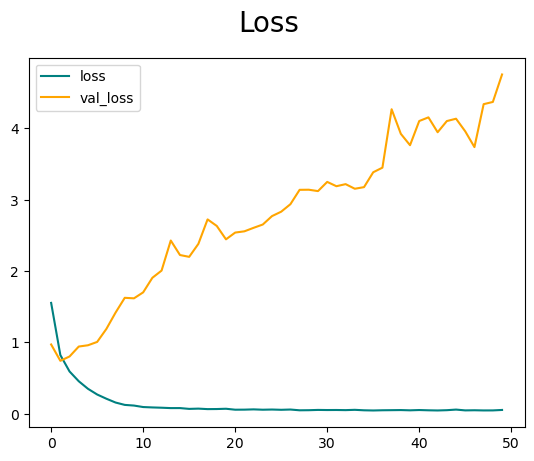

In [50]:
# Plot training and validation loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

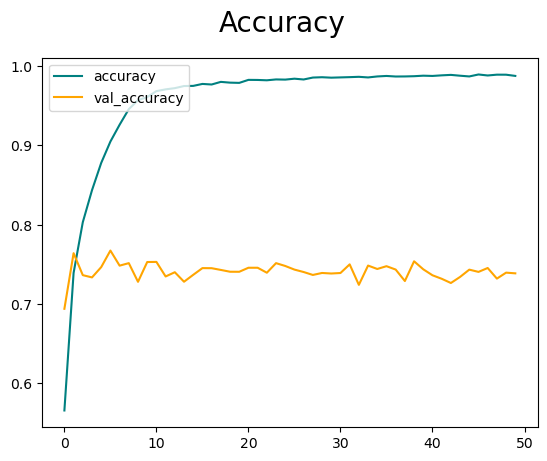

In [51]:
# Plot training and validation accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### 5.4. Evaluation

In [52]:
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall

In [53]:
# Metrics for multi-class classification
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [54]:
# Update metrics over the test dataset
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 22ms/step


In [55]:
# Calculate F1-score
precision = pre.result().numpy()
recall = re.result().numpy()
f1_score = 2 * (precision * recall) / (precision + recall)

In [56]:
# Output performance metrics
print(f'Accuracy: {acc.result().numpy()}, Precision: {precision}, Recall: {recall}, F1-Score: {f1_score}')

Accuracy: 0.7411752343177795, Precision: 0.7425474524497986, Recall: 0.7396179437637329, F1-Score: 0.7410798449068727


### 5.5. Testing

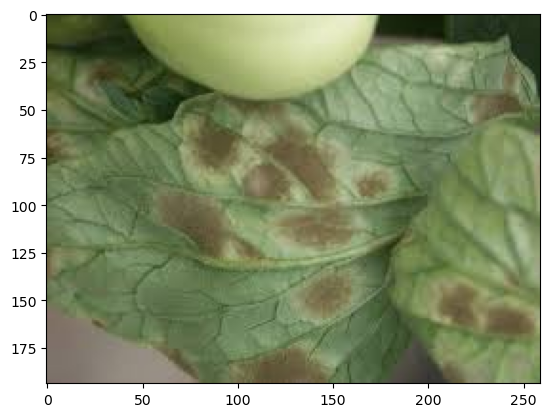

In [57]:
# Load a test image
img = cv2.imread(r'C:\Users\Marvin\Documents\WBS\Final_Project\Data\test_data\images.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

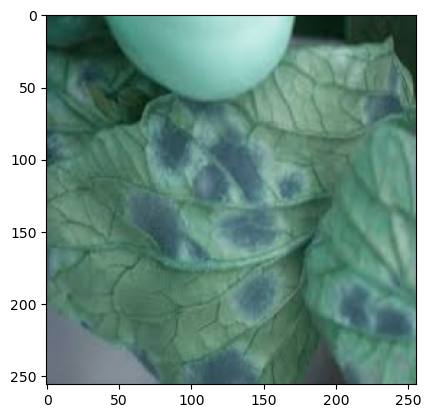

In [58]:
# Resize the image
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [59]:
# Predict the class of the resized image
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 104ms/step


In [60]:
yhat

array([[6.55485983e-23, 0.00000000e+00, 1.71000209e-31, 2.19938459e-22,
        1.32631240e-14, 2.79394705e-28, 1.49189732e-12, 0.00000000e+00,
        9.20858520e-27, 9.86563884e-24, 0.00000000e+00, 8.27585618e-37,
        2.34672715e-26, 2.92179482e-20, 7.61363851e-38, 6.91408788e-34,
        9.89409011e-32, 5.37330346e-21, 1.40778414e-17, 9.99999881e-01,
        8.61664767e-11, 9.33226886e-38, 1.68177243e-29, 1.45823805e-35,
        1.22798125e-38, 6.27569990e-30, 9.07254660e-16, 0.00000000e+00,
        0.00000000e+00, 4.73472139e-32, 8.50887819e-21, 2.93752435e-24,
        0.00000000e+00, 1.47235599e-22, 1.29332085e-38, 1.80646669e-31,
        0.00000000e+00, 1.56177878e-19, 3.48549314e-11, 4.29377679e-11,
        5.29365912e-26, 2.58948600e-27, 1.16357425e-23, 0.00000000e+00,
        0.00000000e+00, 1.09095014e-12, 8.30854390e-08, 5.97266660e-22,
        1.13235712e-12, 8.60003636e-25, 5.35797201e-29, 2.11250482e-24,
        4.91777417e-25, 3.61372665e-09, 1.04388813e-32, 4.565128

In [68]:
predicted_class = np.argmax(yhat) # Index of the class with the maximum prediction value
predicted_class_name = class_names[predicted_class]
print(f'Predicted class: {predicted_class_name}')

Predicted class: Corn___healthy


# 6. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join(r'C:\Users\Marvin\Documents\WBS\Final_Project\Dr.-Greenthumb-Decoding-Nature-s-Needs\Models','healthy_or_wilted_classifier.h5'))

In [ ]:
new_model = load_model(os.path.join(r'C:\Users\Marvin\Documents\WBS\Final_Project\Dr.-Greenthumb-Decoding-Nature-s-Needs\Models','healthy_or_wilted_classifier.h5'))

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 56ms/step


array([[0.999998]], dtype=float32)